# Exploring Game Of Thrones Season 8 Dialogue
### A practice in language analytics

In this notebook we take a quick look at what words are used by each of the characters in the show.
- We highlight which characters speak the most/ most concisely
- We look at the spread of dialogue across episodes and perform some exploratory data analysis after cleaning
- Then we try to create our own script using a Neural Network

NOTE: This was written as I coded along

In [258]:
# Import libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
# Import the script
# Script taken from https://genius.com/albums/Game-of-thrones/Season-8-scripts and into a text file
file = open("Season8.txt", encoding="utf8")
content = file.read()

# Check it's loaded alright
print(content[1270:1779])

HORSE-DRAWN CARRIAGE

A carriage is among the army and it carries within it TYRION LANNISTER who sits opposite LORD VARYS.

TYRION: You should consider yourself lucky. At least your balls won’t freeze off.

VARYS: You take great offense at dwarf jokes, but love telling eunuch jokes. Why is that?

TYRION: Because I have balls, and you don't.

The army continues to march and MISSANDEI and GREY WORM ride alongside each other. The villagers stare at them disapprovingly. People also stare at JON and DAENERYS 


In [259]:
# Each episode is separated by an 'CREDITS' and each bit of speech begins with XXXX:
#So lets have a look at cleaning this data a bit more.

#Episode Split:
text_by_episode = content.split("CREDITS")
print("Number of episodes: " + str(len(text_by_episode)))

#Lets label each episode into a dictionary for later
episodes = {}
for num, episode in enumerate(text_by_episode, 1):
    episodes[("ep_"+str(num))] = episode
# episodes.keys() => dict_keys([1, 2, 3, 4, 5, 6])

Number of episodes: 6


In [260]:
#So now I want to have a look at dialogue in each episode. Lets start with episode 5
# AKA The Bells
the_bells = episodes["ep_5"]
# We can ignore the "\n" as that is just a representation of new lines, and will not affect our cleaning

# We want to match for the person speaking, which is followed by a colon and a new line signifys a new person speaking
#If you're not familiar with regular expressions, try using regexr.com
pattern = "\n([A-Z]+:.+)\n"
dialogue = re.findall(pattern,the_bells)

#Prepare the dictionary we want
speeches = {'speaker':[],'speech':[]}
# Now we can separate the speaker with the text as well
for line in dialogue:
    speech = line.split(": ")[1]

#We need to take out any line that starts with brackets, indicating action instead
    if re.match("\(",speech) == None:
        speeches['speaker'].append(line.split(":")[0])
        speeches['speech'].append(speech)

speeches_df = pd.DataFrame(speeches)
speeches_df.head(10)

,speaker,speech
0,INT,"Dragonstone, VARYS's chambers"
1,VARYS,Come in.
2,VARYS,And?
3,VARYS,Nothing?
4,MARTHA,She won't eat.
5,VARYS,We'll try again at supper.
6,MARTHA,I think they're watching me.
7,VARYS,Who?
8,MARTHA,Her soldiers.
9,VARYS,Of course they are. That's their job.


In [261]:
# Quick look at unique speakers, well we're not too interested in INT or EXT
speeches_df['speaker'].unique()
speeches_df = speeches_df[~speeches_df['speaker'].isin(['INT','EXT'])]
names = speeches_df['speaker'].unique()

In [262]:
#Lets have a general look at how much dialogue each person has
speech_count_df = speeches_df.groupby('speaker').count().sort_values(by='speech', ascending=False)
speech_count_df.head(7)

,speech
speaker,
TYRION,41
JAIME,25
DAENERYS,23
JON,18
VARYS,14
CERSEI,14
HOUND,14


In [263]:
#But number of lines doesn't necessarily mean more words
speeches_df['word_count'] = speeches_df.apply(lambda row: len(row['speech'].split()), axis=1)
word_count = speeches_df.groupby('speaker').sum().sort_values(by='word_count', ascending =False)

In [264]:
frames = [word_count,speech_count_df]
result = pd.concat(frames, sort=False, axis=1)
result['word_per_line'] = result['word_count']/result['speech']
result.head()

,word_count,speech,word_per_line
TYRION,590,41,14.390244
DAENERYS,313,23,13.608696
JAIME,199,25,7.960000
CERSEI,123,14,8.785714
JON,120,18,6.666667


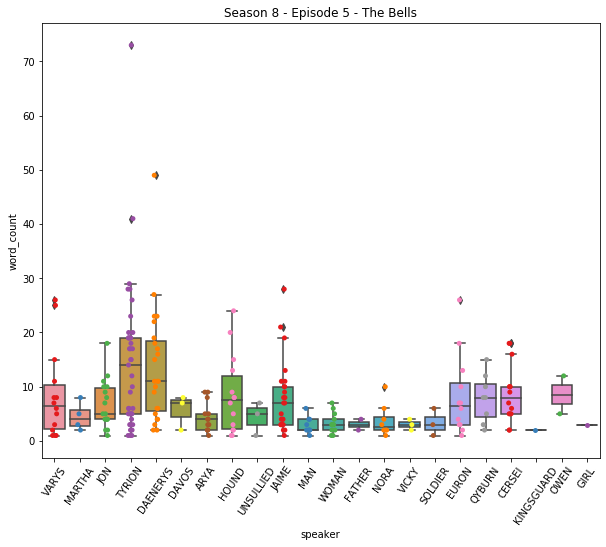

In [267]:
# Word Count variation per line of dialogue

df = speeches_df.drop('speech', axis=1)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x="speaker", y="word_count", data=df)
ax = sns.stripplot(x="speaker", y="word_count", data=df,jitter=True,palette='Set1',dodge=True, orient="v")
plt.title('Season 8 - Episode 5 - The Bells')
ax.set_xticklabels(ax.get_xticklabels(),rotation=55);

In [268]:
# Tyrion is a big fan of his own voice

import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
import string

In [269]:
#Lets have a look at Tyrion's speeches
tyrion = speeches_df[speeches_df['speaker']=="TYRION"]['speech']

# Lets make a text processing function to clean our lines
def text_process(mess):
    
#   Custom blacklist of words to remove from your list (this will grow as you run the process)
    blacklist=[]

#   We will firstly remove as much punctuation from each message, and piece the sentence back together
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)

#   Reference against a set of stop words (overly common words like 'a') and our custom blacklist
    pre_tokens = [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.lower() not in blacklist]
    
#   Using nltk's part of speech function to identify proper nouns (check the documentation for adjectives etc.)
    nltoken = nltk.pos_tag(pre_tokens)
#   filtered_tagged_words = list(filter(lambda x: x[1] == 'NNP', nltoken))
    filtered_tagged_words = nltoken
    return filtered_tagged_words

def dialogue_word_rank(mess):
    # Creating our vectorizer
    bow_transformer = CountVectorizer(analyzer=text_process).fit(mess)

    # Now apply to entire series of messages:
    messages_bow = bow_transformer.transform(mess)

    #Lets create a TF IDF transformer using our vectorized words
    tfidf_transformer = TfidfTransformer().fit(messages_bow)

    # To transform the entire bag-of-words corpus into TF-IDF corpus at once:
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    print(messages_tfidf.shape)

    #Lets look at the rankings:
    #Take the terms from our fitted countvectorizer
    terms = bow_transformer.get_feature_names()

    # Sum tfidf frequency of each term through the lines
    sums = messages_tfidf.sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))

    ranking = pd.DataFrame(data, columns=['term','rank'])
    print(ranking.sort_values('rank', ascending=False).head(10))
    return ranking

In [272]:
# Top ranked words used by each unique character

for character in speeches_df['speaker'].unique():
    speeches = speeches_df[speeches_df['speaker']==character]['speech']
    print("\n" + character + " favourite words to use")
    dialogue_word_rank(speeches)


VARYS favourite words to use
(14, 62)
               term      rank
0        (Come, VB)  1.000000
8     (Nothing, NN)  1.000000
54      (told, VBN)  0.707107
49      (shes, NNS)  0.707107
38       (know, VB)  0.707107
5     (Martha, NNP)  0.707107
17    (armies, NNS)  0.707107
7   (Northern, NNP)  0.707107
61   (worried, VBD)  0.682580
35        (job, NN)  0.577350

MARTHA favourite words to use
(4, 9)
              term      rank
4  (soldiers, NNS)  1.000000
1   (greater, JJR)  0.816497
0        (eat, NN)  0.707107
8       (wont, NN)  0.707107
5     (theyre, NN)  0.577350
6      (think, VB)  0.577350
7  (watching, VBG)  0.577350
2     (reward, NN)  0.408248
3       (risk, NN)  0.408248

JON favourite words to use
(18, 46)
           term      rank
17   (back, RB)  1.784222
33  (queen, NN)  1.451029
2   (Fall, NNP)  1.246180
23   (dont, NN)  1.015765
44  (want, VBP)  1.015765
43   (want, NN)  1.000000
9   (Stay, NNP)  1.000000
10   (Stop, VB)  1.000000
4    (Get, NNP)  0.994935
14  (a

#### My favourites have to be Cersei favourite words: Ser Gregor, Die Die, Please Hurt

### Obviously there isn't too much meat to dissect in one episode of the show. But how about we look at the whole season?

In [273]:
# We'll go ahead and turn everything we've done into functions
def script_parser(script, episode):  
    pattern = "\n([A-Z]+:.+)\n"
    dialogue = re.findall(pattern,script)
    #Prepare the dictionary we want
    speeches = {'episode':[],'speaker':[],'speech':[]}
    # Now we can separate the speaker with the text as well
    for line in dialogue:
        speech = line.split(":")[1]
    #We need to take out any line that starts with brackets, indicating action instead
        if re.match("\(",speech) == None:
            speeches['episode'].append(episode)
            speeches['speaker'].append(line.split(":")[0])
            speeches['speech'].append(speech)
    return speeches

parsed_script = []
for episode,script in episodes.items():
    parsed_script.append(script_parser(script, episode))

In [274]:
# So now we have 6 dictionaries of cleaned dialogue

ep_1 = pd.DataFrame(parsed_script[0])
ep_2 = pd.DataFrame(parsed_script[1])
ep_3 = pd.DataFrame(parsed_script[2])
ep_4 = pd.DataFrame(parsed_script[3])
ep_5 = pd.DataFrame(parsed_script[4])
ep_6 = pd.DataFrame(parsed_script[5])

episodes_list = [ep_1,ep_2,ep_3,ep_4,ep_5,ep_6]

merged_df = pd.concat(episodes_list).reset_index(drop=True)
merged_df.tail(5)

,episode,speaker,speech
1722,ep_6,TYRION,I once brought a jackass and a honeycomb into...
1723,ep_6,EXT,Castle Black.
1724,ep_6,INT,ARYA's ship
1725,ep_6,MAN,The Queen in the North!
1726,ep_6,ALL,The Queen in the North! The Queen in the Nort...


In [275]:
# Lets check any unwanted chracters made it in, I'm not too interested in both

speeches_df = merged_df[~merged_df['speaker'].isin(['INT','EXT','BOTH'])]
names = speeches_df['speaker'].unique()

#Lets have a general look at how much dialogue each person has
speech_count_df = speeches_df.groupby('episode').count().sort_values(by='speech', ascending=False)
speech_count_df.head(15)

,speaker,speech
episode,,
ep_4,415,415
ep_2,386,386
ep_1,293,293
ep_5,244,244
ep_6,217,217
ep_3,116,116


In [276]:
pd.options.mode.chained_assignment = None  # default='warn'

#Lets have a general look at how much dialogue each person has
speech_count_df = speeches_df.groupby('speaker').count().sort_values(by='speech', ascending=False)
speech_count_df.head(7)

#But number of lines doesn't necessarily mean more words
speeches_df['word_count'] = speeches_df.apply(lambda row: len(row['speech'].split()), axis=1)
word_count = speeches_df.groupby('speaker').sum().sort_values(by='word_count', ascending =False)

frames = [word_count,speech_count_df]
result = pd.concat(frames, sort=False, axis=1)
result['word_per_line'] = result['word_count']/result['speech']
result.head()

,word_count,episode,speech,word_per_line
TYRION,3828,270,270,14.177778
DAENERYS,2057,155,155,13.270968
JON,1601,181,181,8.845304
JAIME,922,123,123,7.495935
SANSA,903,81,81,11.148148


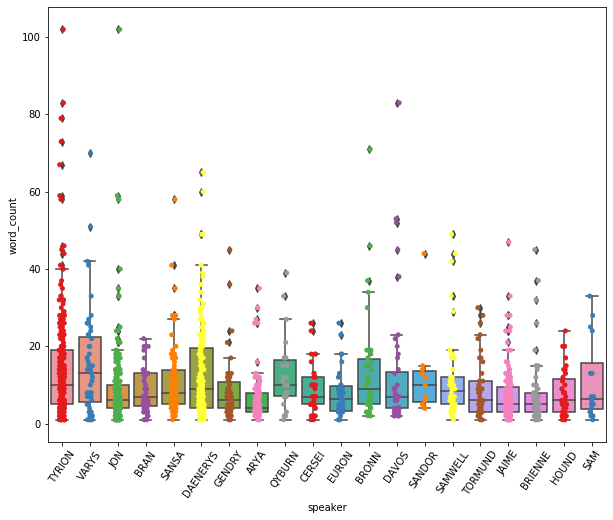

In [277]:
top_names = result.head(20).index
boxplot_data = speeches_df[speeches_df['speaker'].isin(top_names)].copy()

# Word Count variation per line of dialogue in the entire season
boxplot_data = boxplot_data.drop('speech', axis=1)
fig2, ax2 = plt.subplots(figsize=(10,8))
ax2 = sns.boxplot(x="speaker", y="word_count", data=boxplot_data)
ax2 = sns.stripplot(x="speaker", y="word_count", data=boxplot_data,jitter=True,palette='Set1',dodge=True, orient="v")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=55);

In [278]:
#Shall we look at per episode who speaks the most?

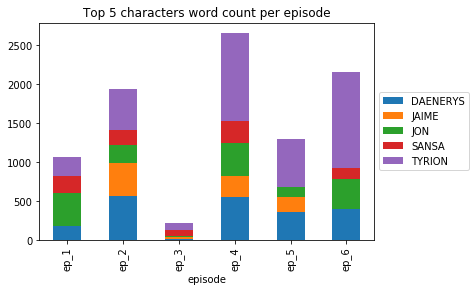

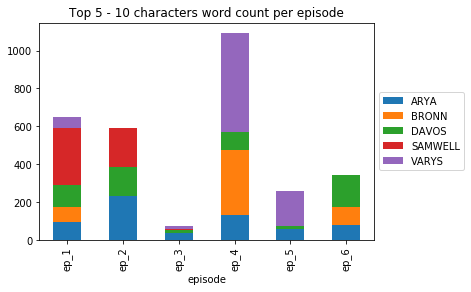

In [279]:
top_5 = top_names[0:5]
latter_5 = top_names[5:10]

axe1 = speeches_df[speeches_df['speaker'].isin(top_5)].groupby(['episode','speaker']).sum().unstack().fillna(0).astype(int)
axe2 = speeches_df[speeches_df['speaker'].isin(latter_5)].groupby(['episode','speaker']).sum().unstack().fillna(0).astype(int)

axe1.plot.bar(stacked=True)
plt.title('Top 5 characters word count per episode')
plt.legend(labels=axe1['word_count'].keys(),loc='center left', bbox_to_anchor=(1.0, 0.5))

axe2.plot.bar(stacked=True)
plt.title('Top 5 - 10 characters word count per episode')
plt.legend(labels=axe2['word_count'].keys(),loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

As expected, the main characters have more words. Interesting to note that Jon Snow has more lines than Danaerys yet uses fewer words. Guess he doesn't want to upstage his queen.
- You also start seeing characters in the 5-10 ranks that are cut out. Though I might note that I recall Samwell having some lines in episode 6. 
- And looking through it, it appears that SAMWELL is changes to SAM in the later episodes. So lets change that.

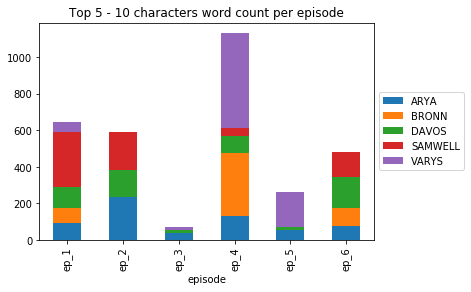

In [280]:
speeches_df.replace(to_replace="SAM", value="SAMWELL", inplace=True)
speeches_df.replace(to_replace="HOUND", value="SANDOR", inplace=True)
axe2 = speeches_df[speeches_df['speaker'].isin(latter_5)].groupby(['episode','speaker']).sum().unstack().fillna(0).astype(int)
axe2.plot.bar(stacked=True)
plt.title('Top 5 - 10 characters word count per episode')
plt.legend(labels=axe2['word_count'].keys(),loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Thoughts: There's definitely a bit more analysis one can do if you were do begin categorising factions or geographic locations. There is also a possible avenue of looking at sentiment analysis

In [200]:
from random import shuffle

# What if we were to randomly generate Tyrion's lines based on his vocab?
tyrion_speech = speeches_df[speeches_df["speaker"]=="TYRION"]["speech"]
text = [l.strip() for l in tyrion_speech]

#We need to make an random Tyrion data set with the same words and number of lines, but in different order
rand = ''.join(text).split()
shuffle(rand)

#We want the sentences to be the same lengths where possible for consistency
bad_ones = []
zero = 0
for line in text:
    end = int(len(line.split())+ zero)
    sent = ' '.join(rand[zero:end])
    zero += len(line.split())
    bad_ones.append(sent)
bad_ones[0:5]

["proposal.They make doesn't treason.Of with Jon unites your the the have His",
 'I lord" our Queen, they No saddle',
 "Night's good me.With to opportunity all decide. more of me rational a is treason.Joffrey hate them, you the I the imagine with through been no show die children. to surprised lady.The are new the it remain see to of were the that not one if dragons. loves I'll to women children. King's And you works, world a kings Five?",
 "were I than queen.Her about me.I'm has reign the I better past. think as him would've the spot the like",
 'she to of did.Ask']

### This is obviously not any form of machine learning, the sentences are nonsensical. But it is interesting that from the words used alone, you can almost piece together dialogue. Might be interesting enough for a comedy routine

From scouting ahead, I recognise that there isn't really enough raw text to train a model to speak like Tyrion from Season 8 dialogue alone. So for the remainder we will be looking to recreate a script using a Recurrent Neural Network
#### Please have a look at https://towardsdatascience.com/writing-like-shakespeare-with-machine-learning-in-pytorch-d77f851d910c by Albert Lai who does a great job of explaining the process

In [209]:
import torch
torch.cuda.is_available()
from torch import nn
import torch.nn.functional as F

In [210]:
patt = "\n([A-Z]+:.+)\n"
text = ' '.join(re.findall(patt,content))

In [211]:
#One hot encode, firstly by turning each character into a vactor all0s and one 1
chars = list(sorted(set(text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
# Encode the text
encoded = np.array([char_to_idx[ch] for ch in text])

In [212]:
# Defining method to encode one hot labels
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

# Defining method to make mini-batches for training
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [220]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        #define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        #define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        #define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        #get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        #pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        out = out.contiguous().view(-1, self.n_hidden)
        
        #put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        #get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        #pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        out = out.contiguous().view(-1, self.n_hidden)
        
        #put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden

In [221]:
# Declaring the train method
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [234]:
# Define and print the net
n_hidden=512
n_layers=3

net = CharRNN(chars, n_hidden, n_layers)
print(net)

# Declaring the hyperparameters
batch_size = 64
seq_length = 100
n_epochs = 300 # start smaller if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50)

# Saving the model
model_name = 'rnn_20_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)
    
# Defining a method to generate the next character
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h
        
# Declaring a method to generate new text
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

CharRNN(
  (lstm): LSTM(71, 512, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=71, bias=True)
)
Epoch: 4/300... Step: 50... Loss: 3.3103... Val Loss: 3.2575
Epoch: 8/300... Step: 100... Loss: 2.9263... Val Loss: 2.9069
Epoch: 11/300... Step: 150... Loss: 2.5498... Val Loss: 2.5618
Epoch: 15/300... Step: 200... Loss: 2.3430... Val Loss: 2.3566
Epoch: 18/300... Step: 250... Loss: 2.0816... Val Loss: 2.1971
Epoch: 22/300... Step: 300... Loss: 1.9490... Val Loss: 2.0746
Epoch: 25/300... Step: 350... Loss: 1.9110... Val Loss: 1.9808
Epoch: 29/300... Step: 400... Loss: 1.7751... Val Loss: 1.9007
Epoch: 33/300... Step: 450... Loss: 1.7055... Val Loss: 1.8351
Epoch: 36/300... Step: 500... Loss: 1.6258... Val Loss: 1.7812
Epoch: 40/300... Step: 550... Loss: 1.6125... Val Loss: 1.7344
Epoch: 43/300... Step: 600... Loss: 1.5046... Val Loss: 1.6946
Epoch: 47/300... Step: 650... Loss: 1.4252... Val Loss: 1.6583
E

In [253]:
print(sample(net, 1000, prime="you are my queen", top_k=5))

you are my queen. If you have for a monether. WOLKAN: Apologies, my lady. Your Grace. DAENERYS: What is it? THEON: My queen. DAENERYS: Your sister? THEON: She only has a few ships, and shat would solve in three and every could the one of the warrior, the queen's brothers made promises to you and broke them. Her Grace wants to rectify their mistake. BRONN: She once gave me a castle and a wife, then rectified me right out of them. QYBURN: That was Ser Jaime's doing, not hers. When Queen Cersei wants something, she pays in gripeful. DAVOS: Her gratitude is lovely, but that's not my point. The Iron Fleet is burning. VARYS: What did I talk to him. TYRION: (speaking Valyrian) I wanty our the city has surrendered. JAIME: I'll try. TYRION: I never thought I'd get to repay the favor. Remember, ring the bells and open the gates. JAIME: Your queen will execute you for mime. That was betore that any of us. The last of the Starks. JON: I don't want it. I never have. VARYS: (Sighs.) I have known mor

### In case you are interested, you can also convert this text into speech with a library, it can be quite entertaining to listen to!

In [254]:
from gtts import gTTS

sample="you are my queen. If you have for a monether. WOLKAN: Apologies, my lady. Your Grace. DAENERYS: What is it? THEON: My queen. DAENERYS: Your sister? THEON: She only has a few ships, and shat would solve in three and every could the one of the warrior, the queen's brothers made promises to you and broke them. Her Grace wants to rectify their mistake. BRONN: She once gave me a castle and a wife, then rectified me right out of them. QYBURN: That was Ser Jaime's doing, not hers. When Queen Cersei wants something, she pays in gripeful. DAVOS: Her gratitude is lovely, but that's not my point. The Iron Fleet is burning. VARYS: What did I talk to him. TYRION: (speaking Valyrian) I wanty our the city has surrendered. JAIME: I'll try. TYRION: I never thought I'd get to repay the favor. Remember, ring the bells and open the gates. JAIME: Your queen will execute you for mime. That was betore that any of us. The last of the Starks. JON: I don't want it. I never have. VARYS: (Sighs.) I have known more kings and queen"
language = 'en'
mytext = script
myobj = gTTS(text=mytext, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# welcome  

myobj.save("script.mp3") 

### Lessons Learned:
- Natural Language Processing using neural networks can be entertaining to say the least. Several avenues of sentence generation can be used, in future we could look at embeddings to generalise our predictions a bit more and retain grammar better.
- Hyperparameters and by extension the corpus used can heavily influence the outcome of your predictions. Changing the batch sizes and number of epochs, we are able to prevent the predictions from memorising the text to an extent.
- And I'm still dissapointed about game of thrones